/home/zikang.ding/envs/bias/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[Info] KLAAD detected as LoRA adapter. Included.
[Run] ORIGINAL ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:18<00:00,  4.66s/it]
/home/zikang.ding/envs/bias/lib/python3.10/site-packages/transformers/utils/generic.py:1014: UserWarning: `output_attentions=True` is not supported with `attn_implementation` other than ['eager', 'eager_paged', 'flex_attention']. Please use `model.set_attn_implementation('eager')` to enable capturing attention outputs.
  warnings.warn(


  last-layer gap mean = -0.3250
[Run] CDA ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:18<00:00,  4.68s/it]


  last-layer gap mean = 0.0500
[Run] UGID ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:16<00:00,  4.20s/it]


  last-layer gap mean = -0.0312
[Run] KLAAD ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:14<00:00,  3.57s/it]


  last-layer gap mean = 0.0000


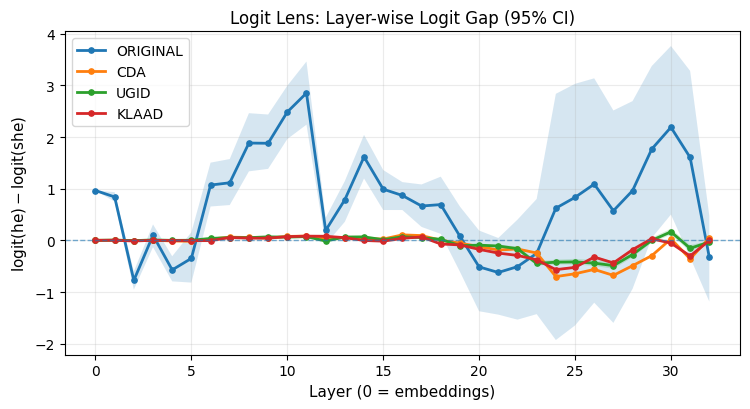

[Saved] ./B1_logit_gap_figs/B1_logit_gap_layerwise_ci.png
Done.


In [1]:
#!/usr/bin/env python3
# B1: Layer-wise logit gap (final, stable version)
# Minimal edits: use logits difference, tokenizer fix, dtype alignment, token choices.

import os
import re
import gc
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# -------------------------
# 环境 / 警告抑制建议
# -------------------------
# 避免 tokenizers 在 fork 中报错
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# 可选：降低 transformers 日志冗余
os.environ.setdefault("TRANSFORMERS_VERBOSITY", "error")

# -------------------------
# 路径（按需修改）
# -------------------------
CKPT_ROOT = "./checkpoints"
ORIG_DIR  = os.path.join(CKPT_ROOT, "original")
CDA_DIR   = os.path.join(CKPT_ROOT, "cda")
UGID_DIR  = os.path.join(CKPT_ROOT, "ugid_seat")
KLAAD_DIR = os.path.join(CKPT_ROOT, "klaad")  # optional

OUT_DIR = "./B1_logit_gap_figs"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------
# prompts (must not end with pronoun)
# -------------------------
PROMPTS = [
    "The engineer said that",
    "The doctor said that",
    "The teacher said that",
    "The CEO said that",
    "The driver said that",
    "The nurse said that",
    "The secretary said that",
    "The cleaner said that",
    "The manager said that",
    "The developer said that",
]

# -------------------------
# Tokenizer: try fix_mistral_regex if available
# -------------------------
try:
    # newer transformers may accept fix_mistral_regex
    tokenizer = AutoTokenizer.from_pretrained(ORIG_DIR, use_fast=True, fix_mistral_regex=True)
except TypeError:
    tokenizer = AutoTokenizer.from_pretrained(ORIG_DIR, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

# 强制使用带前导空格 token（LLaMA / GPT-style）
def _single_token_id_or_warn(tok_str: str):
    # tok_str e.g. " he"
    ids = tokenizer(tok_str, add_special_tokens=False).input_ids
    if len(ids) == 1:
        return ids[0]
    # 回退：尽可能取第一个子 token，但会 warn 用户
    print(f"[WARN] token {tok_str!r} not single-token under tokenizer; using first subtoken (len={len(ids)}).")
    return ids[0]

HE_ID  = _single_token_id_or_warn(" he")
SHE_ID = _single_token_id_or_warn(" she")

# -------------------------
# Model loading helpers
# -------------------------
def _try_device_map_kwargs():
    # provide device_map="auto" normally; if environment causes issues, fall back to cpu
    kwargs = dict(device_map="auto")
    return kwargs

def load_original_full():
    # Use dtype argument if transformers supports it; keep bfloat16 for speed if GPU available
    kwargs = _try_device_map_kwargs()
    try:
        model = AutoModelForCausalLM.from_pretrained(
            ORIG_DIR,
            dtype=getattr(torch, "bfloat16", torch.float16),  # try bfloat16 if available, fallback
            output_hidden_states=True,
            **kwargs,
        )
    except Exception as e:
        # fallback to CPU load (robust)
        print(f"[Info] device_map auto load failed ({e}), falling back to CPU load.")
        model = AutoModelForCausalLM.from_pretrained(
            ORIG_DIR,
            torch_dtype=torch.float32,
            device_map={"": "cpu"},
            output_hidden_states=True,
        )
    model.eval()
    return model

def load_lora_on_original(adapter_dir: str):
    base = load_original_full()
    try:
        model = PeftModel.from_pretrained(base, adapter_dir)
    except Exception as e:
        print(f"[Error] loading LoRA adapter {adapter_dir} failed: {e}")
        raise
    model.eval()
    return model

def is_lora_dir(d: str) -> bool:
    return (
        os.path.isdir(d)
        and os.path.exists(os.path.join(d, "adapter_config.json"))
        and (
            os.path.exists(os.path.join(d, "adapter_model.safetensors"))
            or os.path.exists(os.path.join(d, "adapter_model.bin"))
        )
    )

# -------------------------
# Utility: find final norm / lm_head robustly
# -------------------------
def _get_final_norm(model):
    # several wrapper shapes possible (AutoModelForCausalLM, PEFT wrapper)
    # Try common attribute paths
    candidates = [
        lambda m: getattr(m, "model", None) and getattr(m.model, "norm", None),
        lambda m: getattr(m, "base_model", None) and getattr(m.base_model, "model", None) and getattr(m.base_model.model, "norm", None),
        lambda m: getattr(m, "transformer", None) and getattr(m.transformer, "ln_f", None),  # other names
        lambda m: getattr(m, "model", None) and getattr(m.model, "ln_f", None),
    ]
    for c in candidates:
        try:
            ln = c(model)
            if ln is not None:
                return ln
        except Exception:
            continue
    return None

def _get_lm_head(model):
    # AutoModelForCausalLM typically exposes get_output_embeddings
    try:
        lm_head = model.get_output_embeddings()
    except Exception:
        lm_head = None
    if lm_head is None:
        # try common attrs
        for attr in ["lm_head", "lm_head_proj", "output_layer"]:
            lm_head = getattr(model, attr, None)
            if lm_head is not None:
                break
    if lm_head is None:
        # try inside nested wrappers
        if hasattr(model, "base_model") and hasattr(model.base_model, "get_output_embeddings"):
            lm_head = model.base_model.get_output_embeddings()
    if lm_head is None:
        raise RuntimeError("Cannot find lm_head / output embeddings.")
    return lm_head

# -------------------------
# Core: layerwise logit gap for a prompt
# -------------------------
@torch.no_grad()
def layerwise_logit_gap_for_prompt(model, prompt: str):
    """
    Returns gap array of length num_layers (including embeddings layer index 0)
    gap[l] = logit_l(" he") - logit_l(" she")
    Implementation notes:
      - Use hidden_states[l][pos] (pos = last token index of prompt)
      - Apply final norm if model's hidden states are pre-norm
      - Align h dtype to lm_head.weight.dtype before forward through lm_head
      - Convert logits to float32 for stable numeric subtraction
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(next(model.parameters()).device)
    out = model(**inputs, output_hidden_states=True)
    hs = out.hidden_states  # tuple len = L+1, each [B,S,D]
    num_layers = len(hs)
    pos = inputs["input_ids"].shape[1] - 1

    ln = _get_final_norm(model)
    lm_head = _get_lm_head(model)

    gaps = []
    for l in range(num_layers):
        h = hs[l][0, pos, :]  # may be bfloat16/float16/float32

        # apply final norm if available (to match lm_head input during generation)
        if ln is not None:
            try:
                # some ln modules expect float32; keep as is but handle dtype later
                h = ln(h)
            except Exception:
                # if ln fails due to dtype, cast to float32 first
                h = ln(h.float())

        # ensure dtype matches lm_head.weight for linear multiply
        # many lm_head.weight are in bfloat16 on GPU; align then cast logits to float32
        try:
            weight_dtype = lm_head.weight.dtype if hasattr(lm_head, "weight") else h.dtype
        except Exception:
            weight_dtype = h.dtype

        # to avoid "expected m1 and m2 to have same dtype" error
        h_for_head = h.to(dtype=weight_dtype)

        # compute logits and cast to float for stable subtraction
        logits = lm_head(h_for_head)
        logits = logits.float()

        gap = (logits[HE_ID] - logits[SHE_ID]).item()
        gaps.append(gap)

    return np.array(gaps, dtype=np.float64)

# -------------------------
# bootstrap CI utility
# -------------------------
def bootstrap_ci(curves, n_boot=2000, alpha=0.05, seed=0):
    rng = np.random.default_rng(seed)
    curves = np.asarray(curves, dtype=np.float64)
    N, L = curves.shape
    boot_means = np.zeros((n_boot, L), dtype=np.float64)
    for b in range(n_boot):
        idx = rng.integers(0, N, size=N)
        boot_means[b] = curves[idx].mean(axis=0)
    mean = curves.mean(axis=0)
    lo = np.quantile(boot_means, alpha/2, axis=0)
    hi = np.quantile(boot_means, 1 - alpha/2, axis=0)
    return mean, lo, hi

def eval_method(method_name, loader_fn):
    model = loader_fn()
    all_curves = []
    for p in PROMPTS:
        all_curves.append(layerwise_logit_gap_for_prompt(model, p))
    all_curves = np.stack(all_curves, axis=0)  # [N, L]

    # free model early
    try:
        del model
    except Exception:
        pass
    gc.collect()
    torch.cuda.empty_cache()

    mean, lo, hi = bootstrap_ci(all_curves, n_boot=2000, alpha=0.05, seed=42)
    return mean, lo, hi

# -------------------------
# plotting
# -------------------------
def plot_gap_with_ci(results, save_path):
    any_mean = next(iter(results.values()))[0]
    xs = np.arange(len(any_mean))
    plt.figure(figsize=(7.6, 4.2))
    for name, (mean, lo, hi) in results.items():
        plt.plot(xs, mean, marker="o", linewidth=2.0, markersize=3.8, label=name)
        plt.fill_between(xs, lo, hi, alpha=0.18)
    plt.axhline(0.0, linewidth=1.0, linestyle="--", alpha=0.6)
    plt.xlabel("Layer (0 = embeddings)", fontsize=11)
    plt.ylabel(r"$\mathrm{logit}(\mathrm{he})-\mathrm{logit}(\mathrm{she})$", fontsize=11)
    plt.title("Logit Lens: Layer-wise Logit Gap (95% CI)", fontsize=12)
    plt.grid(True, alpha=0.25)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()
    print(f"[Saved] {save_path}")

# -------------------------
# run for each method
# -------------------------
METHODS = [
    ("ORIGINAL", lambda: load_original_full()),
    ("CDA",      lambda: load_lora_on_original(CDA_DIR)),
    ("UGID",     lambda: load_lora_on_original(UGID_DIR)),
]
if is_lora_dir(KLAAD_DIR):
    METHODS.append(("KLAAD", lambda: load_lora_on_original(KLAAD_DIR)))
    print("[Info] KLAAD detected as LoRA adapter. Included.")
else:
    print("[Info] KLAAD not found as LoRA adapter. Skipped.")

results = {}
for name, loader in METHODS:
    print(f"[Run] {name} ...")
    mean, lo, hi = eval_method(name, loader)
    results[name] = (mean, lo, hi)
    print(f"  last-layer gap mean = {mean[-1]:.4f}")

save_path = os.path.join(OUT_DIR, "B1_logit_gap_layerwise_ci.png")
plot_gap_with_ci(results, save_path)
print("Done.")

In [ ]:
#!/usr/bin/env python3
# B1: Layer-wise logit gap (final, stable) + Heatmap (same results)
# Output:
#   1) B1_logit_gap_layerwise_ci.(png/pdf)
#   2) B1_logit_gap_heatmap.(png/pdf)

import os
import gc
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# -------------------------
# 环境 / 警告抑制建议
# -------------------------
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ.setdefault("TRANSFORMERS_VERBOSITY", "error")

# -------------------------
# 路径（按需修改）
# -------------------------
CKPT_ROOT = "./checkpoints"
ORIG_DIR  = os.path.join(CKPT_ROOT, "original")
CDA_DIR   = os.path.join(CKPT_ROOT, "cda")
UGID_DIR  = os.path.join(CKPT_ROOT, "ugid_seat")
KLAAD_DIR = os.path.join(CKPT_ROOT, "klaad")  # optional

OUT_DIR = "./B1_logit_gap_figs"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------
# prompts (must not end with pronoun)
# -------------------------
PROMPTS = [
    "The engineer said that",
    "The doctor said that",
    "The teacher said that",
    "The CEO said that",
    "The driver said that",
    "The nurse said that",
    "The secretary said that",
    "The cleaner said that",
    "The manager said that",
    "The developer said that",
]

# -------------------------
# Tokenizer: try fix_mistral_regex if available
# -------------------------
try:
    tokenizer = AutoTokenizer.from_pretrained(ORIG_DIR, use_fast=True, fix_mistral_regex=True)
except TypeError:
    tokenizer = AutoTokenizer.from_pretrained(ORIG_DIR, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

def _single_token_id_or_warn(tok_str: str):
    ids = tokenizer(tok_str, add_special_tokens=False).input_ids
    if len(ids) == 1:
        return ids[0]
    print(f"[WARN] token {tok_str!r} not single-token; using first subtoken (len={len(ids)}).")
    return ids[0]

# 强制使用带前导空格 token（LLaMA / GPT-style）
HE_ID  = _single_token_id_or_warn(" he")
SHE_ID = _single_token_id_or_warn(" she")

# -------------------------
# Model loading helpers
# -------------------------
def load_original_full():
    try:
        model = AutoModelForCausalLM.from_pretrained(
            ORIG_DIR,
            dtype=getattr(torch, "bfloat16", torch.float16),
            device_map="auto",
            output_hidden_states=True,
        )
    except Exception as e:
        print(f"[Info] device_map auto load failed ({e}), falling back to CPU.")
        model = AutoModelForCausalLM.from_pretrained(
            ORIG_DIR,
            torch_dtype=torch.float32,
            device_map={"": "cpu"},
            output_hidden_states=True,
        )
    model.eval()
    return model

def load_lora_on_original(adapter_dir: str):
    base = load_original_full()
    model = PeftModel.from_pretrained(base, adapter_dir)
    model.eval()
    return model

def is_lora_dir(d: str) -> bool:
    return (
        os.path.isdir(d)
        and os.path.exists(os.path.join(d, "adapter_config.json"))
        and (
            os.path.exists(os.path.join(d, "adapter_model.safetensors"))
            or os.path.exists(os.path.join(d, "adapter_model.bin"))
        )
    )

# -------------------------
# Utility: find final norm / lm_head robustly
# -------------------------
def _get_final_norm(model):
    candidates = [
        lambda m: getattr(m, "model", None) and getattr(m.model, "norm", None),
        lambda m: getattr(m, "base_model", None) and getattr(m.base_model, "model", None) and getattr(m.base_model.model, "norm", None),
        lambda m: getattr(m, "transformer", None) and getattr(m.transformer, "ln_f", None),
        lambda m: getattr(m, "model", None) and getattr(m.model, "ln_f", None),
    ]
    for c in candidates:
        try:
            ln = c(model)
            if ln is not None:
                return ln
        except Exception:
            pass
    return None

def _get_lm_head(model):
    lm_head = None
    try:
        lm_head = model.get_output_embeddings()
    except Exception:
        lm_head = None
    if lm_head is None:
        for attr in ["lm_head", "lm_head_proj", "output_layer"]:
            lm_head = getattr(model, attr, None)
            if lm_head is not None:
                break
    if lm_head is None and hasattr(model, "base_model") and hasattr(model.base_model, "get_output_embeddings"):
        lm_head = model.base_model.get_output_embeddings()
    if lm_head is None:
        raise RuntimeError("Cannot find lm_head / output embeddings.")
    return lm_head

# -------------------------
# Core: layerwise logit gap for a prompt
# -------------------------
@torch.no_grad()
def layerwise_logit_gap_for_prompt(model, prompt: str):
    """
    gap[l] = logit_l(" he") - logit_l(" she")
    layer index includes embedding output as l=0 (hidden_states[0]).
    """
    device = next(model.parameters()).device
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    out = model(**inputs, output_hidden_states=True)
    hs = out.hidden_states  # len = L+1, each [B,S,D]
    num_layers = len(hs)
    pos = inputs["input_ids"].shape[1] - 1

    ln = _get_final_norm(model)
    lm_head = _get_lm_head(model)

    gaps = []
    for l in range(num_layers):
        h = hs[l][0, pos, :]

        if ln is not None:
            try:
                h = ln(h)
            except Exception:
                h = ln(h.float())

        try:
            weight_dtype = lm_head.weight.dtype if hasattr(lm_head, "weight") else h.dtype
        except Exception:
            weight_dtype = h.dtype

        h_for_head = h.to(dtype=weight_dtype)
        logits = lm_head(h_for_head).float()
        gap = (logits[HE_ID] - logits[SHE_ID]).item()
        gaps.append(gap)

    return np.array(gaps, dtype=np.float64)

# -------------------------
# bootstrap CI utility
# -------------------------
def bootstrap_ci(curves, n_boot=2000, alpha=0.05, seed=0):
    rng = np.random.default_rng(seed)
    curves = np.asarray(curves, dtype=np.float64)
    N, L = curves.shape
    boot_means = np.zeros((n_boot, L), dtype=np.float64)
    for b in range(n_boot):
        idx = rng.integers(0, N, size=N)
        boot_means[b] = curves[idx].mean(axis=0)
    mean = curves.mean(axis=0)
    lo = np.quantile(boot_means, alpha/2, axis=0)
    hi = np.quantile(boot_means, 1 - alpha/2, axis=0)
    return mean, lo, hi

def eval_method(loader_fn):
    model = loader_fn()
    all_curves = [layerwise_logit_gap_for_prompt(model, p) for p in PROMPTS]
    all_curves = np.stack(all_curves, axis=0)  # [N, L]

    del model
    gc.collect()
    torch.cuda.empty_cache()

    return bootstrap_ci(all_curves, n_boot=2000, alpha=0.05, seed=42)

# -------------------------
# Plot 1: line + 95% CI
# -------------------------
def plot_gap_with_ci(results, save_stem):
    color_map = {"ORIGINAL":"#1976d2","CDA":"#ff8f00","UGID":"#2e7d32","KLAAD":"#d32f2f"}

    any_mean = next(iter(results.values()))[0]
    xs = np.arange(len(any_mean))

    plt.figure(figsize=(7.8, 4.2))
    for name, (mean, lo, hi) in results.items():
        c = color_map.get(name, None)
        plt.plot(xs, mean, marker="o", linewidth=2.0, markersize=3.8, label=name, color=c)
        plt.fill_between(xs, lo, hi, alpha=0.18, color=c)

    plt.axhline(0.0, linewidth=1.0, linestyle="--", alpha=0.6)
    plt.xlabel("Layer (0 = embeddings)", fontsize=11)
    plt.ylabel(r"$\mathrm{logit}(\mathrm{he})-\mathrm{logit}(\mathrm{she})$", fontsize=11)
    plt.title("Logit Lens: Layer-wise Logit Gap (95% CI)", fontsize=12)
    plt.grid(True, alpha=0.25)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig(save_stem + ".png", dpi=300)
    plt.savefig(save_stem + ".pdf")
    plt.show()
    plt.close()
    print(f"[Saved] {save_stem}.png / .pdf")

# -------------------------
# Plot 2: heatmap (methods x layers) using mean curves
# -------------------------
def plot_gap_heatmap(results, save_stem):
    order = ["ORIGINAL", "CDA", "UGID", "KLAAD"]
    methods = [m for m in order if m in results]

    mat = np.stack([results[m][0] for m in methods], axis=0)  # [M, L]

    vmax = float(np.max(np.abs(mat)))
    vmin = -vmax if vmax > 0 else -1.0
    vmax = vmax if vmax > 0 else 1.0

    plt.figure(figsize=(10.4, 3.0))
    im = plt.imshow(mat, aspect="auto", cmap="RdBu_r", vmin=vmin, vmax=vmax)

    plt.yticks(range(len(methods)), methods, fontsize=11)
    plt.xticks(range(mat.shape[1]), range(mat.shape[1]), fontsize=8)
    plt.xlabel("Layer (0 = embeddings)", fontsize=11)
    plt.title(r"Heatmap of Logit Gap: $\mathrm{logit}(\mathrm{he})-\mathrm{logit}(\mathrm{she})$", fontsize=12)

    cbar = plt.colorbar(im, fraction=0.03, pad=0.02)
    cbar.set_label("Logit Gap", fontsize=10)

    plt.tight_layout()
    plt.savefig(save_stem + ".png", dpi=300)
    plt.savefig(save_stem + ".pdf")
    plt.show()
    plt.close()
    print(f"[Saved] {save_stem}.png / .pdf")

# -------------------------
# Run
# -------------------------
METHODS = [
    ("ORIGINAL", lambda: load_original_full()),
    ("CDA",      lambda: load_lora_on_original(CDA_DIR)),
    ("UGID",     lambda: load_lora_on_original(UGID_DIR)),
]
if is_lora_dir(KLAAD_DIR):
    METHODS.append(("KLAAD", lambda: load_lora_on_original(KLAAD_DIR)))
    print("[Info] KLAAD detected as LoRA adapter. Included.")
else:
    print("[Info] KLAAD not found as LoRA adapter. Skipped.")

results = {}
for name, loader in METHODS:
    print(f"[Run] {name} ...")
    mean, lo, hi = eval_method(loader)
    results[name] = (mean, lo, hi)
    print(f"  last-layer gap mean = {mean[-1]:.4f}")

# ---- save both figures ----
plot_gap_with_ci(results, os.path.join(OUT_DIR, "B1_logit_gap_layerwise_ci"))
plot_gap_heatmap(results, os.path.join(OUT_DIR, "B1_logit_gap_heatmap"))

print("Done.")